In [45]:
import numpy as np
import pandas as pd



In [46]:
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
# Add the 'diagnosis' column (target variable) to the DataFrame
df['diagnosis'] = data.target

# Drop non-feature columns (adjust if needed), ensuring 'diagnosis' is not in X
X = df.drop(columns=['diagnosis']).values

# Standardization (important!)
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [47]:


class KMeans:
    def __init__(
        self,
        n_clusters=3,
        init="kmeans++",   # "random" or "kmeans++"
        max_iter=300,
        tol=1e-4,
        random_state=None
    ):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.centroids = None
        self.labels_ = None
        self.inertia_history_ = []

    # ---------------------------
    # Initialization
    # ---------------------------
    def _init_random(self, X):
        rng = np.random.default_rng(self.random_state)
        indices = rng.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _init_kmeans_pp(self, X):
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]

        centroids = []
        # choose first centroid randomly
        centroids.append(X[rng.integers(n_samples)])

        for _ in range(1, self.n_clusters):
            distances = np.min(
                np.linalg.norm(X[:, None, :] - np.array(centroids)[None, :, :], axis=2) ** 2,
                axis=1
            )
            probs = distances / np.sum(distances)
            next_centroid = X[rng.choice(n_samples, p=probs)]
            centroids.append(next_centroid)

        return np.array(centroids)

    # ---------------------------
    # Core steps
    # ---------------------------
    def _assign_clusters(self, X):
        distances = np.linalg.norm(
            X[:, None, :] - self.centroids[None, :, :],
            axis=2
        )
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = np.zeros_like(self.centroids)
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                new_centroids[k] = self.centroids[k]  # avoid empty cluster
            else:
                new_centroids[k] = np.mean(cluster_points, axis=0)
        return new_centroids

    def _compute_inertia(self, X, labels):
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            inertia += np.sum((cluster_points - self.centroids[k]) ** 2)
        return inertia

    # ---------------------------
    # Fit
    # ---------------------------
    def fit(self, X):
        if self.init == "random":
            self.centroids = self._init_random(X)
        elif self.init == "kmeans++":
            self.centroids = self._init_kmeans_pp(X)
        else:
            raise ValueError("init must be 'random' or 'kmeans++'")

        for _ in range(self.max_iter):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)

            shift = np.linalg.norm(self.centroids - new_centroids)
            self.centroids = new_centroids

            inertia = self._compute_inertia(X, labels)
            self.inertia_history_.append(inertia)

            if shift < self.tol:
                break

        self.labels_ = labels
        return self

    # ---------------------------
    # Predict
    # ---------------------------
    def predict(self, X):
        distances = np.linalg.norm(
            X[:, None, :] - self.centroids[None, :, :],
            axis=2
        )
        return np.argmin(distances, axis=1)


In [48]:
def silhouette_score(X, labels):
    n = X.shape[0]
    unique_labels = np.unique(labels)

    silhouette_vals = []

    for i in range(n):
        same_cluster = labels == labels[i]
        other_clusters = labels != labels[i]

        # a(i): mean intra-cluster distance
        a = np.mean(np.linalg.norm(X[i] - X[same_cluster], axis=1))

        # b(i): minimum mean distance to other clusters
        b = np.inf
        for label in unique_labels:
            if label == labels[i]:
                continue
            cluster_points = X[labels == label]
            dist = np.mean(np.linalg.norm(X[i] - cluster_points, axis=1))
            b = min(b, dist)

        silhouette_vals.append((b - a) / max(a, b))

    return np.mean(silhouette_vals)


In [49]:

k_values = range(2, 11)

results = {
    "k": [],
    "inertia": [],
    "silhouette": [],
    "iterations": []
}

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        init="kmeans++",
        max_iter=300,
        tol=1e-4,
        random_state=42
    )

    kmeans.fit(X)

    results["k"].append(k)
    results["inertia"].append(kmeans.inertia_history_[-1])
    results["silhouette"].append(silhouette_score(X, kmeans.labels_))
    results["iterations"].append(len(kmeans.inertia_history_))

In [50]:
def run_kmeans(init_type):
    inertias = []
    iters = []

    for k in k_values:
        km = KMeans(
            n_clusters=k,
            init=init_type,
            max_iter=300,
            tol=1e-4,
            random_state=42
        )
        km.fit(X)
        inertias.append(km.inertia_history_[-1])
        iters.append(len(km.inertia_history_))

    return inertias, iters


inertia_random, iter_random = run_kmeans("random")
inertia_pp, iter_pp = run_kmeans("kmeans++")


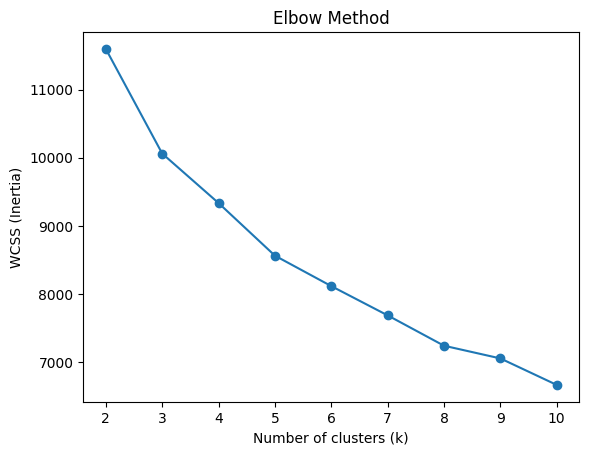

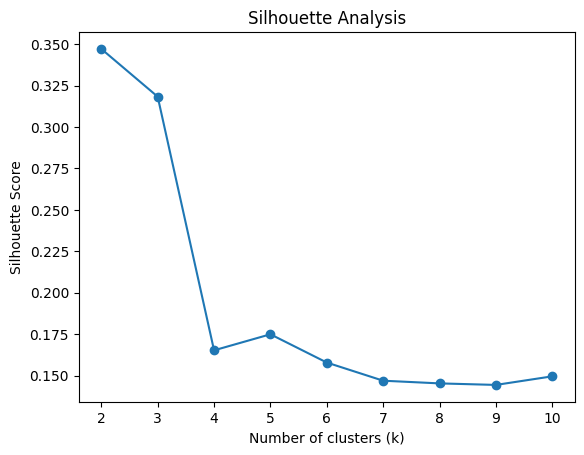

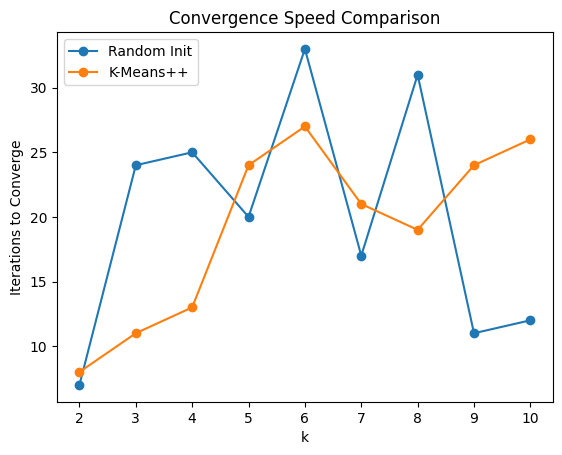

In [51]:
import matplotlib.pyplot as plt

# Elbow curve
plt.figure()
plt.plot(k_values, results["inertia"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method")
plt.show()

# Silhouette curve
plt.figure()
plt.plot(k_values, results["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

# Convergence comparison
plt.figure()
plt.plot(k_values, iter_random, label="Random Init", marker="o")
plt.plot(k_values, iter_pp, label="K-Means++", marker="o")
plt.xlabel("k")
plt.ylabel("Iterations to Converge")
plt.legend()
plt.title("Convergence Speed Comparison")
plt.show()


Davies–Bouldin Index

In [52]:
def davies_bouldin_index(X, labels, centroids):
    k = len(centroids)
    scatter = np.zeros(k)

    for i in range(k):
        cluster_points = X[labels == i]
        scatter[i] = np.mean(
            np.linalg.norm(cluster_points - centroids[i], axis=1)
        )

    db_index = 0
    for i in range(k):
        max_ratio = 0
        for j in range(k):
            if i != j:
                dist = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (scatter[i] + scatter[j]) / dist
                max_ratio = max(max_ratio, ratio)
        db_index += max_ratio

    return db_index / k


Calinski–Harabasz Index

In [53]:
def calinski_harabasz_index(X, labels, centroids):
    n = X.shape[0]
    k = len(centroids)
    overall_mean = np.mean(X, axis=0)

    between = 0
    within = 0

    for i in range(k):
        cluster_points = X[labels == i]
        ni = len(cluster_points)

        between += ni * np.sum((centroids[i] - overall_mean) ** 2)
        within += np.sum((cluster_points - centroids[i]) ** 2)

    return (between / (k - 1)) / (within / (n - k))


External Metrics (Purity + ARI + NMI)

In [54]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def purity_score(y_true, y_pred):
    total = 0
    for cluster in np.unique(y_pred):
        indices = y_pred == cluster
        true_labels = y_true[indices]
        total += np.max(np.bincount(true_labels))
    return total / len(y_true)


Confusion Matrix

In [55]:
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)), dtype=int)

    for i, true_label in enumerate(labels):
        for j, pred_label in enumerate(labels):
            matrix[i, j] = np.sum(
                (y_true == true_label) & (y_pred == pred_label)
            )
    return matrix


Run FULL Evaluation for Optimal k

In [56]:
# choose k from elbow/silhouette
optimal_k = 3   # change if your analysis says otherwise

kmeans = KMeans(
    n_clusters=optimal_k,
    init="kmeans++",
    random_state=42
)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.centroids

# Internal metrics
sil = silhouette_score(X, labels)
db = davies_bouldin_index(X, labels, centroids)
ch = calinski_harabasz_index(X, labels, centroids)

# External metrics
# In load_breast_cancer, 0 is malignant, 1 is benign.
# The original code (df["diagnosis"] == "M") implies 'M' (malignant) should be 1.
# So, we set y_true to 1 when diagnosis is 0 (malignant).
y_true = (df["diagnosis"] == 0).astype(int).values

ari = adjusted_rand_score(y_true, labels)
nmi = normalized_mutual_info_score(y_true, labels)
purity = purity_score(y_true, labels)

print("Silhouette:", sil)
print("Davies-Bouldin:", db)
print("Calinski-Harabasz:", ch)
print("ARI:", ari)
print("NMI:", nmi)
print("Purity:", purity)

Silhouette: 0.31833711977562645
Davies-Bouldin: 1.5293883767807952
Calinski-Harabasz: 197.1140002277671
ARI: 0.510670959369618
NMI: 0.42229582618320705
Purity: 0.8699472759226714


Confusion Matrix Heatmap

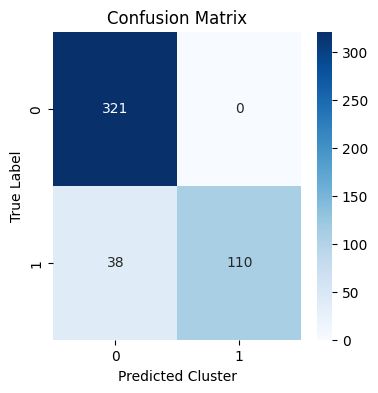

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, labels)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


2D Visualization (PCA for visualization only)

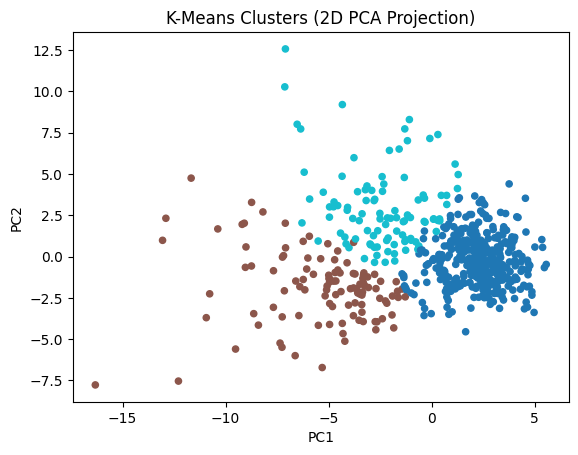

In [58]:
# PCA for visualization (NOT clustering)
X_centered = X - np.mean(X, axis=0)
cov = np.cov(X_centered, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov)

idx = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:, idx[:2]]

X_2d = X_centered @ eigvecs

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=20)
plt.title("K-Means Clusters (2D PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [59]:
import pandas as pd

summary = pd.DataFrame({
    "Metric": ["Silhouette", "Davies-Bouldin", "Calinski-Harabasz", "ARI", "NMI", "Purity"],
    "Value": [sil, db, ch, ari, nmi, purity]
})

summary


,Metric,Value
0,Silhouette,0.318337
1,Davies-Bouldin,1.529388
2,Calinski-Harabasz,197.114000
3,ARI,0.510671
4,NMI,0.422296
5,Purity,0.869947
